In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm
import random

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [132]:
def load_mnist_subset(selected_classes=[0, 1, 2, 3, 4], train_split=0.8, max_samples=2000):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: torch.flatten(x))
    ])

    full_train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    full_test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    def get_indices(dataset, classes):
        indices = []
        for i in range(len(dataset)):
            if dataset.targets[i] in classes:
                indices.append(i)
        return indices

    train_indices_all = get_indices(full_train_data, selected_classes)

    if max_samples and len(train_indices_all) > max_samples:
        random.seed(42)
        random.shuffle(train_indices_all)
        train_indices_all = train_indices_all[:max_samples]

    filtered_train_data = Subset(full_train_data, train_indices_all)

    num_total = len(filtered_train_data)
    num_train = int(train_split * num_total)
    num_val = num_total - num_train

    train_subset, val_subset = torch.utils.data.random_split(filtered_train_data, [num_train, num_val])

    test_indices = get_indices(full_test_data, selected_classes)
    if len(test_indices) > 1000:
        test_indices = test_indices[:1000]
    test_subset = Subset(full_test_data, test_indices)

    return train_subset, val_subset, test_subset

In [133]:
class FCNN(nn.Module):
    def __init__(self, input_dim=784, hidden_layers=[128, 64, 32], output_dim=5):
        super(FCNN, self).__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [134]:
def initialize_model(hidden_layers, initial_weights, device):
    model = FCNN(hidden_layers=hidden_layers).to(device)
    model.load_state_dict(initial_weights)
    return model

In [135]:
def get_optimizer(model, opt_name, lr=0.001):
    if opt_name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)
    elif opt_name == 'batch_gd':
        return optim.SGD(model.parameters(), lr=lr)
    elif opt_name == 'momentum':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif opt_name == 'nag':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    elif opt_name == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-8)
    elif opt_name == 'adam':
        return optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

In [136]:
def get_data_on_device(train_subset, val_subset, device):
    def subset_to_tensor(subset):
        loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
        for X, y in loader:
            return X.to(device), y.to(device)

    X_train, y_train = subset_to_tensor(train_subset)
    X_val, y_val = subset_to_tensor(val_subset)
    return X_train, y_train, X_val, y_val

In [137]:
def train_one_epoch(model, X_train, y_train, optimizer, criterion, batch_size):
    model.train()
    num_samples = X_train.size(0)
    running_loss = 0.0
    correct_train = 0

    if batch_size == 1:
        indices = torch.randperm(num_samples, device=X_train.device)
        for i in indices:
            X_sample = X_train[i:i+1]
            y_sample = y_train[i:i+1]

            optimizer.zero_grad(set_to_none=True)
            outputs = model(X_sample)
            loss = criterion(outputs, y_sample)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == y_sample).sum().item()

    else:
        optimizer.zero_grad(set_to_none=True)
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss = loss.item() * num_samples

        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == y_train).sum().item()

    avg_loss = running_loss / num_samples
    train_acc = correct_train / num_samples
    return avg_loss, train_acc

In [138]:
def validate_one_epoch(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        outputs = model(X_val)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_val).sum().item()
        total = y_val.size(0)
    return correct / total

In [139]:
def check_convergence(epoch, prev_loss, avg_loss, threshold):
    loss_diff = abs(prev_loss - avg_loss)
    if epoch > 0 and loss_diff < threshold:
        return True, loss_diff
    return False, loss_diff

In [140]:
def check_convergence(epoch, prev_loss, avg_loss, threshold):
    loss_diff = abs(prev_loss - avg_loss)
    if epoch > 0 and loss_diff < threshold:
        print(f"\n  Converged at Epoch {epoch+1}. Loss Diff: {loss_diff:.6f}")
        return True, loss_diff
    return False, loss_diff

In [141]:
def train_model(train_subset, val_subset, optimizer_name, initial_weights, hidden_layers, batch_size_mode):
    model = initialize_model(hidden_layers, initial_weights, device)
    X_train, y_train, X_val, y_val = get_data_on_device(train_subset, val_subset, device)

    if batch_size_mode == 'full':
        batch_size = len(train_subset)
    else:
        batch_size = 1

    optimizer = get_optimizer(model, optimizer_name)
    criterion = nn.CrossEntropyLoss()

    history = {'loss': [], 'val_acc': [], 'train_acc': []}
    prev_loss = float('inf')
    max_epochs = 2000
    threshold = 1e-4
    epochs_run = 0

    pbar = tqdm(range(max_epochs), desc=f"{optimizer_name}", unit="ep", ncols=100, leave=True)

    for epoch in pbar:
        avg_loss, train_acc = train_one_epoch(model, X_train, y_train, optimizer, criterion, batch_size)
        history['loss'].append(avg_loss)
        history['train_acc'].append(train_acc)

        val_acc = validate_one_epoch(model, X_val, y_val)
        history['val_acc'].append(val_acc)

        converged, loss_diff = check_convergence(epoch, prev_loss, avg_loss, threshold)

        pbar.set_postfix(loss=f"{avg_loss:.4f}", tr_acc=f"{train_acc:.2f}", diff=f"{loss_diff:.4f}")

        prev_loss = avg_loss
        epochs_run = epoch + 1

        if converged:
            pbar.close()
            print(f"  {optimizer_name} Converged at Epoch {epochs_run}. Loss Diff: {loss_diff:.6f}")
            break

    return model, history, epochs_run

In [142]:
def evaluate_best_model(model, test_subset):
    test_loader = DataLoader(test_subset, batch_size=1024)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, cm

In [143]:
def plot_results(results, hidden_layers, max_epochs=100):
    plt.figure(figsize=(12, 6))

    for opt_name, data in results.items():
        loss = data['history']['loss'][:max_epochs]
        plt.plot(loss, label=f"{opt_name} (shown: {len(loss)})")

    plt.title(f"Training Loss Convergence (Layers: {hidden_layers})")
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()


In [144]:
def setup_experiments():
    train_subset, val_subset, test_subset = load_mnist_subset(selected_classes=[0,1,2,3,4], max_samples=2000)
    hidden_layers = [128, 64, 32]
    dummy_model = FCNN(hidden_layers=hidden_layers)
    initial_weights = copy.deepcopy(dummy_model.state_dict())
    return train_subset, val_subset, test_subset, hidden_layers, initial_weights

In [145]:
def run_all_experiments(optimizers_config, train_subset, val_subset, initial_weights, hidden_layers):
    results = {}
    for opt_name, batch_mode in optimizers_config.items():
        print(f"\nRunning {opt_name.upper()}...")
        model, history, epochs_taken = train_model(
            train_subset, val_subset,
            optimizer_name=opt_name,
            initial_weights=initial_weights,
            hidden_layers=hidden_layers,
            batch_size_mode=batch_mode
        )
        final_val_acc = history['val_acc'][-1]
        results[opt_name] = {
            'model': model,
            'history': history,
            'epochs': epochs_taken,
            'val_acc': final_val_acc
        }
        print(f"  Result: Val Acc={final_val_acc:.4f}, Epochs={epochs_taken}")
    return results

In [146]:
def analyze_results(results, test_subset, train_subset, hidden_layers): # Added train_subset argument
    plot_results(results, hidden_layers, 500)
    best_opt = max(results, key=lambda k: results[k]['val_acc'])
    best_res = results[best_opt]
    print(f"\nBest Optimizer: {best_opt} with Validation Accuracy: {best_res['val_acc']:.4f}")

    # Evaluate on Test Data
    test_acc, test_cm = evaluate_best_model(best_res['model'], test_subset)
    print(f"Test Accuracy (Best Model): {test_acc:.4f}")
    print("Test Confusion Matrix:")
    print(test_cm)

    # Evaluate on Training Data
    train_acc, train_cm = evaluate_best_model(best_res['model'], train_subset)
    print(f"Training Accuracy (Best Model): {train_acc:.4f}")
    print("Training Confusion Matrix:")
    print(train_cm)

    # Plot Test CM
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Test Confusion Matrix ({best_opt})")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Plot Train CM
    plt.subplot(1, 2, 2)
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"Training Confusion Matrix ({best_opt})")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.show()


--- Starting Task 4 Experiments (Layers: [128, 64, 32]) ---

Running SGD...


sgd:   2%|▎              | 44/2000 [01:46<1:19:01,  2.42s/ep, diff=0.0001, loss=0.0020, tr_acc=1.00]


  Converged at Epoch 45. Loss Diff: 0.000096
  sgd Converged at Epoch 45. Loss Diff: 0.000096
  Result: Val Acc=0.9500, Epochs=45

Running BATCH_GD...



batch_gd:   0%|                     | 0/2000 [00:00<?, ?ep/s, diff=0.0000, loss=1.6106, tr_acc=0.20]



  Converged at Epoch 2. Loss Diff: 0.000048
  batch_gd Converged at Epoch 2. Loss Diff: 0.000048
  Result: Val Acc=0.1975, Epochs=2

Running MOMENTUM...


momentum:   1%|          | 12/2000 [00:31<1:26:20,  2.61s/ep, diff=0.0001, loss=0.0003, tr_acc=1.00]


  Converged at Epoch 13. Loss Diff: 0.000092
  momentum Converged at Epoch 13. Loss Diff: 0.000092
  Result: Val Acc=0.9600, Epochs=13

Running NAG...



nag:   1%|               | 12/2000 [00:32<1:28:40,  2.68s/ep, diff=0.0001, loss=0.0003, tr_acc=1.00]


  Converged at Epoch 13. Loss Diff: 0.000062
  nag Converged at Epoch 13. Loss Diff: 0.000062
  Result: Val Acc=0.9475, Epochs=13

Running RMSPROP...



rmsprop:   2%|▏          | 36/2000 [01:41<1:32:12,  2.82s/ep, diff=0.0000, loss=0.0000, tr_acc=1.00]


  Converged at Epoch 37. Loss Diff: 0.000000
  rmsprop Converged at Epoch 37. Loss Diff: 0.000000
  Result: Val Acc=0.9625, Epochs=37

Running ADAM...



adam:   2%|▏             | 33/2000 [01:36<1:35:44,  2.92s/ep, diff=0.0000, loss=0.0000, tr_acc=1.00]


  Converged at Epoch 34. Loss Diff: 0.000022
  adam Converged at Epoch 34. Loss Diff: 0.000022
  Result: Val Acc=0.9675, Epochs=34


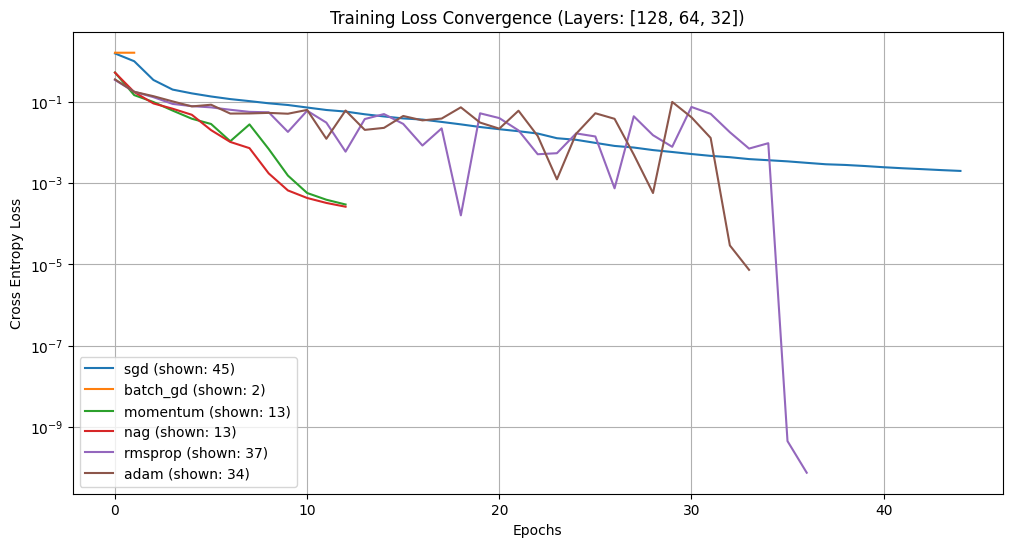


Best Optimizer: adam with Validation Accuracy: 0.9675
Test Accuracy (Best Model): 0.9710
Test Confusion Matrix:
[[163   0   1   2   0]
 [  0 221   1   0   1]
 [  3   5 194   3   2]
 [  0   1   4 192   1]
 [  0   2   3   0 201]]
Training Accuracy (Best Model): 1.0000
Training Confusion Matrix:
[[303   0   0   0   0]
 [  0 335   0   0   0]
 [  0   0 326   0   0]
 [  0   0   0 350   0]
 [  0   0   0   0 286]]


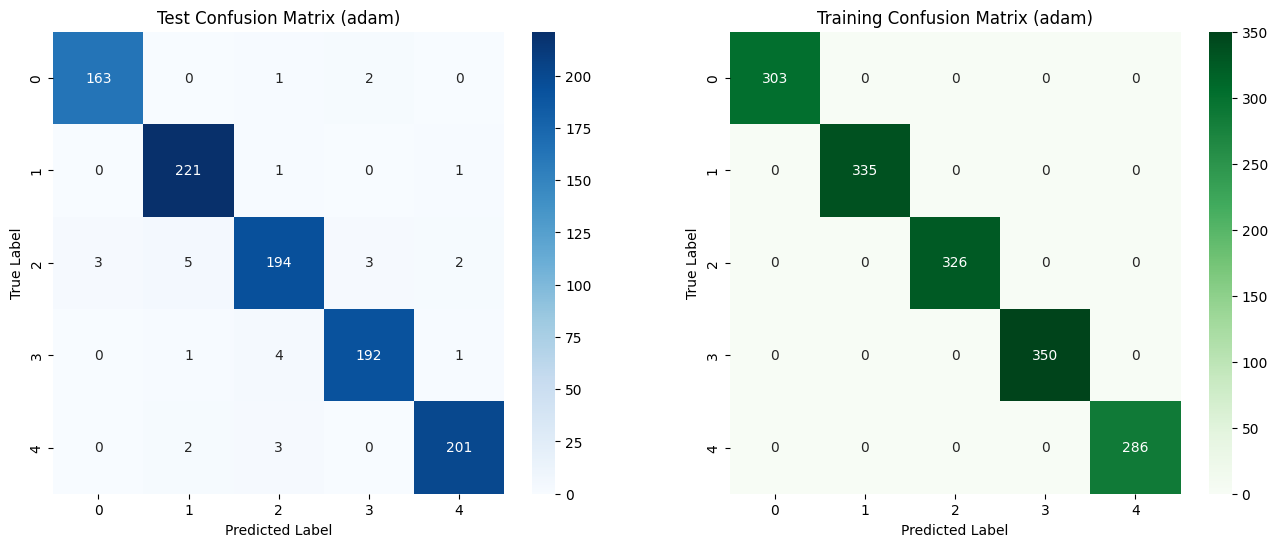

In [147]:
train_subset, val_subset, test_subset, hidden_layers, initial_weights = setup_experiments()

optimizers_config = {
    'sgd': 'stochastic',
    'batch_gd': 'full',
    'momentum': 'stochastic',
    'nag': 'stochastic',
    'rmsprop': 'stochastic',
    'adam': 'stochastic'
}

print(f"\n--- Starting Task 4 Experiments (Layers: {hidden_layers}) ---")
results = run_all_experiments(optimizers_config, train_subset, val_subset, initial_weights, hidden_layers)

analyze_results(results, test_subset, train_subset, hidden_layers)